# **Data Preprocessing**

In [47]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (17, 5)

In [48]:
AUDIO_DIR = '/Users/kaushikpatil/Desktop/CSYE7105_FinalProject/data/genres/'

In [49]:
get_genre = lambda filename : filename.split('.')[0]

def get_filenames(AUDIO_DIR):

    filenames = []
    for _, dirs, files in os.walk(AUDIO_DIR, topdown=False):
        if dirs == []:
            for file in files:
                filenames.append(file)
    return filenames

def get_path(audio_dir, filename):
    
    # Adds back leading zeros for the track ID we want.
    folder = get_genre(filename)
    # The audio file is stored in folders with the leading three digits of the audio filename.
    return os.path.join(AUDIO_DIR, folder, filename)

In [50]:
# Test functions work properly
filenames = get_filenames(AUDIO_DIR)
filenames.sort()
assert len(filenames) == 1000
assert get_path(AUDIO_DIR, filenames[0]) == "/Users/kaushikpatil/Desktop/CSYE7105_FinalProject/data/genres/blues/blues.00000.wav"

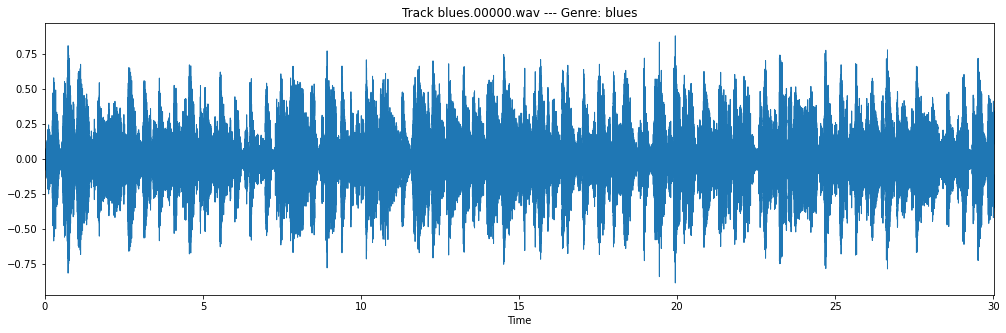

In [51]:
filename = filenames[0]
filepath = get_path(AUDIO_DIR, filename)
genre = filename.split('.')[0]
y, sr = librosa.load(filepath)
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Track {} --- Genre: {}'.format(filename, genre))
plt.show()

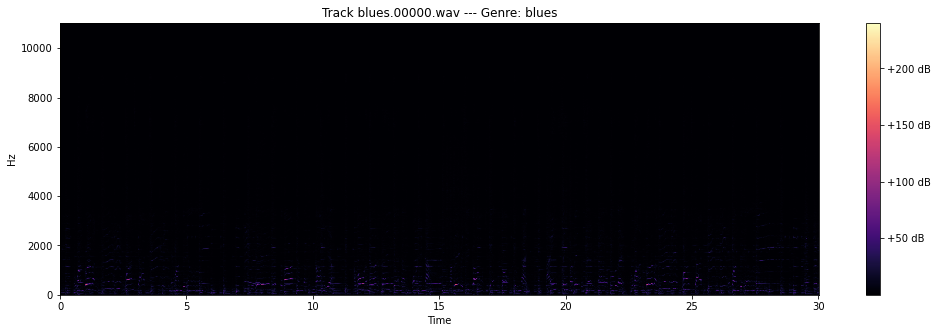

In [52]:
D = np.abs(librosa.stft(y))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
plt.title('Track {} --- Genre: {}'.format(filename, genre))
plt.colorbar(format='%+2.0f dB')
plt.show()

### **Feature Extraction: Mel-Spectrogram**

**Mel-Spectrogram** is the function that I will extract from the audio files and then will store all the spectrograms in the npz format.

In [53]:
SR = 22050
HOP_LENGTH = 1024
N_FFT = 2048
N_MELS = 128

def log_melspectrogram(filename, *, plot=False, genre_label=''):
    
    filepath = get_path(AUDIO_DIR, filename)
    
    y, _ = librosa.load(filepath)
    
    melspec = librosa.feature.melspectrogram(y=y, sr=SR, hop_length=HOP_LENGTH, n_fft=N_FFT, n_mels=N_MELS)

    melspec = librosa.power_to_db(melspec, ref=np.max)

    if plot:
            
        if genre_label != '':
            
            plt.title('Track {} --- Genre: {}'.format(filename, genre_label))
            
        else:
            
            plt.title('Track {}'.format(filename))
            
        librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=SR, fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.show()

    return melspec

In [54]:
def batch_create_log_melspectrograms(filenames):
    
    melspecs = np.empty((0, 128, 640))
    genres = []
    
    for i, filename in enumerate(filenames):

        # Generate the log melspectrogram
        melspec = log_melspectrogram(filename)

        # Not all of the melspecs have the same dimensions, therefore, I decided to cut off 
        # anything after 640. This is just the time frame, so lossing some data here in the las couple ms.
        melspec = melspec[:,:640]

        # So in my experience np.concatenate is much faster than append.
        # Therefore we append the first element and then concatenate after for the 
        # rest of the elements.
        if i == 0:
            melspecs = np.append(melspecs, [melspec], axis=0)
        else:
            melspecs = np.concatenate((melspecs, [melspec]), axis=0)

        # Save genre
        genre = get_genre(filename)
        genres.append(genre)

        # Progress update
        if (i+1) % 100 == 0:
            print('Finished {} tracks'.format(i+1))
            
    melspecs = np.array(melspecs)
    labels = np.array(genres)
    
    return melspecs, labels

### **Display Mel-Spectrogram log**

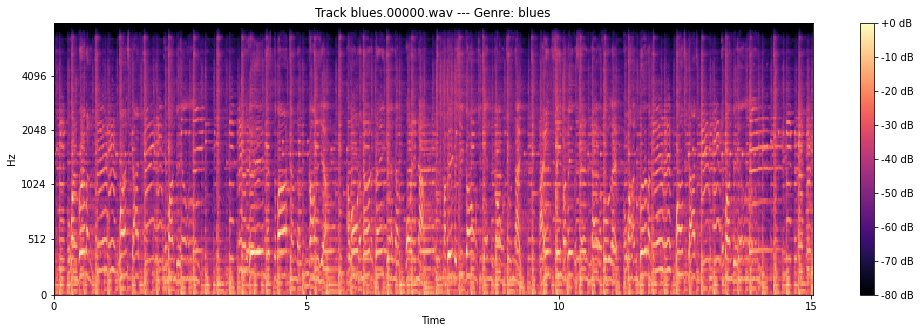

In [55]:
filename = filenames[0]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

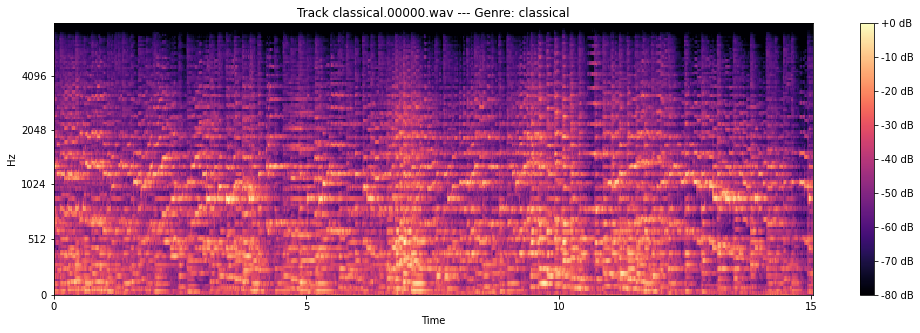

In [56]:
filename = filenames[100]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

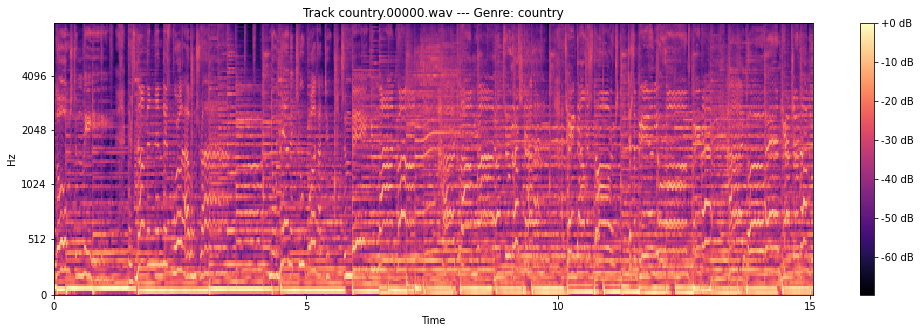

In [57]:
filename = filenames[200]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

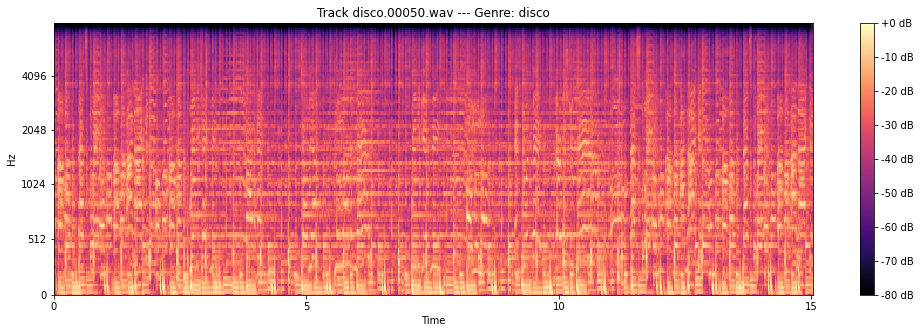

In [58]:
filename = filenames[350]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

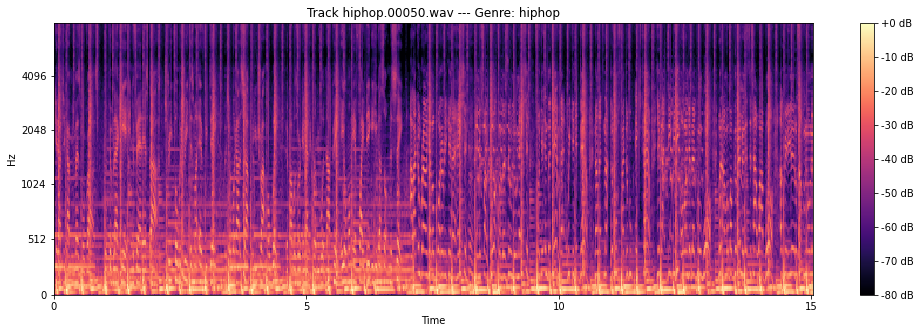

In [59]:
filename = filenames[450]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

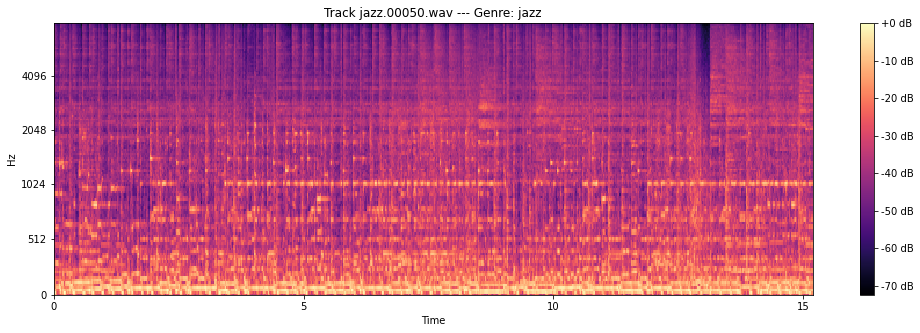

In [60]:
filename = filenames[550]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

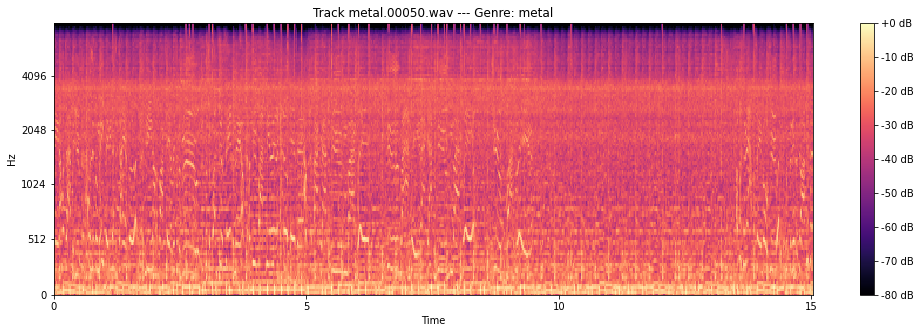

In [61]:
filename = filenames[650]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

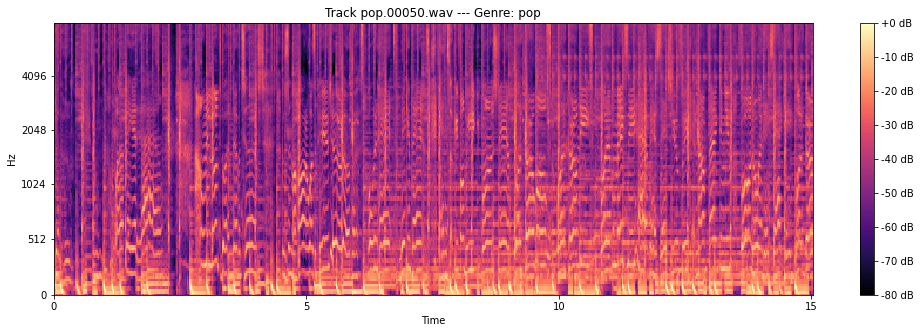

In [62]:
filename = filenames[750]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

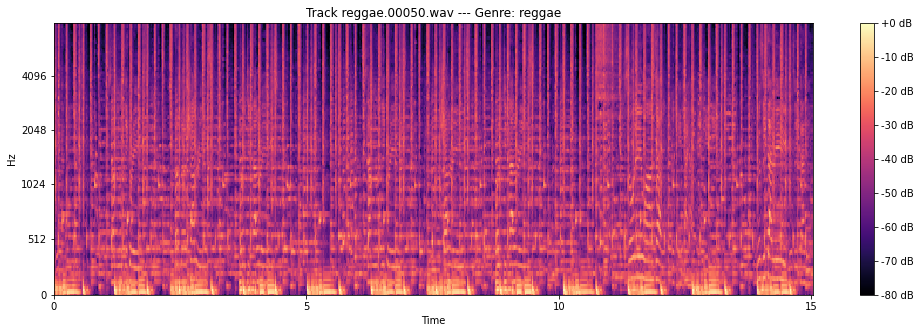

In [63]:
filename = filenames[850]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

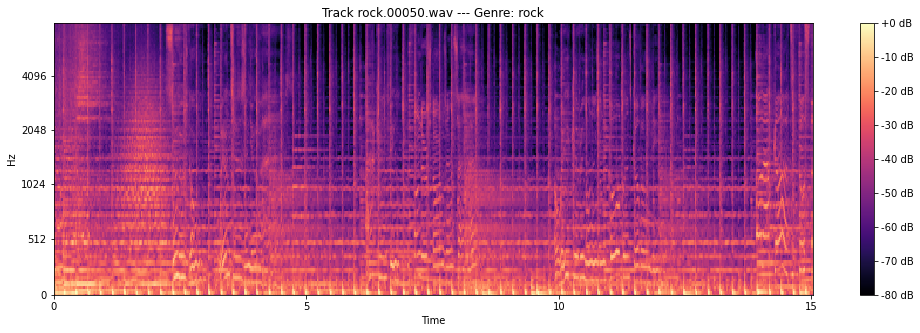

In [64]:
filename = filenames[950]
genre = filename.split('.')[0]
log_melspectrogram(filename, plot=True, genre_label=genre);

### **Create Mel-Spectrograms log**

In [65]:
melspecs, labels = batch_create_log_melspectrograms(filenames)

Finished 100 tracks
Finished 200 tracks
Finished 300 tracks
Finished 400 tracks
Finished 500 tracks
Finished 600 tracks
Finished 700 tracks
Finished 800 tracks
Finished 900 tracks
Finished 1000 tracks


In [66]:
X_train, X_test, y_train, y_test = train_test_split(melspecs, labels, shuffle=True, test_size=0.1)

In [67]:
X_train.shape

(900, 128, 640)

In [68]:
unique, counts = np.unique(y_train, return_counts=True)
for (u, c) in zip(unique, counts):
    print('{} : {}'.format(u, c))

blues : 93
classical : 92
country : 90
disco : 92
hiphop : 89
jazz : 93
metal : 86
pop : 87
reggae : 90
rock : 88


The Distribution of genres is fairly even, so we don't have to worry about our models being biased towards one genre.

### **Labels**

In [69]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
le.classes_

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [70]:
label_train = le.transform(y_train)
label_test = le.transform(y_test)

In [71]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

### **Storing the Data**

In [72]:
np.savez('/Users/kaushikpatil/Desktop/CSYE7105_FinalProject/data/melspect.npz', X_train=X_train, y_train=label_train, 
         X_test=X_test, y_test=label_test)